In [7]:
import numpy as np
import pandas as pd
import utils
from experiment.experiment_utils import set_random_seed, load_data, build_data, grid_search, makedir, save_result, load_data_multitask, load_data_multitask_synthetic_label, load_task_label
from model import LogisticRegression
from pipeline.diffprep_flex_pipeline import DiffPrepFlexPipeline
from pipeline.diffprep_fix_pipeline import DiffPrepFixPipeline
import torch
import torch.nn as nn
from trainer.diffprep_trainer import DiffPrepSGD
from utils import SummaryWriter
from experiment.experiment_utils import min_max_normalize
from copy import deepcopy

In [17]:
LABEL = 'price'#'SalePrice>150k'

In [9]:
def load_prep_pipeline(path, prep_space, params, data_dir, dataset):

    X, y = load_data_multitask(data_dir, dataset)
    X_train, y_train, X_val, y_val, X_test, y_test = build_data(X, y, random_state=params["split_seed"])

    prep_pipeline = DiffPrepFixPipeline(prep_space, temperature=params["temperature"],
                                use_sample=params["sample"],
                                diff_method=params["diff_method"],
                                init_method=params["init_method"])
    prep_pipeline.init_parameters(X_train, X_val, X_test)
    prep_pipeline.load_state_dict(torch.load(path))
    # prep_pipeline.is_fitted = True
    # prep_pipeline.fit(X_train)
    #prep_pipeline.eval()

    return prep_pipeline

In [10]:
class DiffPrepExperiment(object):
    """Run auto prep with one set of hyper parameters"""
    def __init__(self, data_dir, dataset, prep_space, model_name, method, similarity_threshold, fixed_pipeline_path=None):
        self.data_dir = data_dir
        self.dataset = dataset
        self.prep_space = prep_space
        self.model_name = model_name
        self.method = method
        self.similarity_threshold = similarity_threshold
        self.fixed_pipeline_path = fixed_pipeline_path

    def run(self, params, verbose=True):        
        X, y = load_data_multitask_synthetic_label(self.data_dir, self.dataset, similarity_threshold=self.similarity_threshold)
        # override the label
        y = load_task_label(f'result/diffprep_fix/{self.dataset}/{LABEL}_{self.similarity_threshold}')
        #X, y = load_data_multitask(self.data_dir, self.dataset)
        X_train, y_train, X_val, y_val, X_test, y_test = build_data(X, y, random_state=params["split_seed"])
        
        print("Dataset shapes: ", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

        # pre norm for diffprep flex
        if self.method == "diffprep_flex":
            X_train, X_val, X_test = min_max_normalize(X_train, X_val, X_test)
            params["patience"] = 10
            params["num_epochs"] = 3000

        # set random seed
        set_random_seed(params)
        ## transform pipeline
        # define and fit first step
        if self.fixed_pipeline_path:
            #prep_pipeline = self.fixed_pipeline
            prep_pipeline = DiffPrepFixPipeline(self.prep_space, temperature=params["temperature"],
                                use_sample=False,
                                diff_method=params["diff_method"],
                                init_method=params["init_method"])
            prep_pipeline.init_parameters(X_train, X_val, X_test)
            prep_pipeline.load_state_dict(torch.load(self.fixed_pipeline_path))
            prep_pipeline.fit(X_train)
            prep_pipeline.is_fitted = True

        elif self.method == "diffprep_fix":
            prep_pipeline = DiffPrepFixPipeline(self.prep_space, temperature=params["temperature"],
                                             use_sample=params["sample"],
                                             diff_method=params["diff_method"],
                                             init_method=params["init_method"])
            prep_pipeline.init_parameters(X_train, X_val, X_test)
        elif self.method == "diffprep_flex":
            prep_pipeline = DiffPrepFlexPipeline(self.prep_space, temperature=params["temperature"],
                            use_sample=params["sample"],
                            diff_method=params["diff_method"],
                            init_method=params["init_method"])
            prep_pipeline.init_parameters(X_train, X_val, X_test)
        else:
            raise Exception("Wrong auto prep method")

        #prep_pipeline.init_parameters(X_train, X_val, X_test)
        print("Train size: ({}, {})".format(X_train.shape[0], prep_pipeline.out_features))

        # model
        input_dim = prep_pipeline.out_features
        output_dim = len(set(y.values.ravel()))

        # model = TwoLayerNet(input_dim, output_dim)
        set_random_seed(params)
        if self.model_name == "log":
            model = LogisticRegression(input_dim, output_dim)
        else:
            raise Exception("Wrong model")

        model = model.to(params["device"])

        # loss
        loss_fn = nn.CrossEntropyLoss()

        # optimizer
        model_optimizer = torch.optim.SGD(
            model.parameters(),
            lr=params["model_lr"],
            weight_decay=params["weight_decay"],
            momentum=params["momentum"]
        )
        
        if params["prep_lr"] is None:
            prep_lr = params["model_lr"]
        else:
            prep_lr = params["prep_lr"]
    
        prep_pipeline_optimizer = None
        # torch.optim.Adam(
        #     prep_pipeline.parameters(),
        #     lr=prep_lr,
        #     betas=(0.5, 0.999),
        #     weight_decay=params["weight_decay"]
        # )

        # scheduler
        # model_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, patience=patience, factor=0.1, threshold=0.001)
        prep_pipeline_scheduler = None
        model_scheduler = None

        if params["logging"]:
            logger = SummaryWriter()
        else:
            logger = None

        diff_prep = DiffPrepSGD(prep_pipeline, model, loss_fn, model_optimizer, prep_pipeline_optimizer,
                    model_scheduler, prep_pipeline_scheduler, params, writer=logger, train_pipeline=False)

        result, best_model = diff_prep.fit(X_train, y_train, X_val, y_val, X_test, y_test)
        return result, best_model, logger

In [11]:
def run_diffprep(data_dir, dataset, result_dir, prep_space, params, model_name, method, prep_pipeline_path):
    print("Dataset:", dataset, "Diff Method:", params["diff_method"], method)

    diff_prep_exp = DiffPrepExperiment(data_dir, dataset, prep_space, model_name, method, similarity_threshold=params["similarity_threshold"], fixed_pipeline_path=prep_pipeline_path)
    best_result, best_model, best_logger, best_params = grid_search(diff_prep_exp, deepcopy(params))
    save_result(best_result, best_model, best_logger, best_params, result_dir, save_model=True)
    print("DiffPrep Finished. val acc:", best_result["best_val_acc"], "test acc", best_result["best_test_acc"])
    return best_result, best_model, best_logger, best_params

In [12]:
import utils
from prep_space import space
from experiment.baseline_experiment import run_baseline
import os

# define hyper parameters
params = {
    "num_epochs": 2000,
    "batch_size": 512,
    "device": "cpu",
    #"model_lr": [0.1, 0.01, 0.001],
    "model_lr": 0.01,
    "weight_decay": 0,
    "model": 'log',
    "train_seed": 1,
    "split_seed": 1,
    "method": "diffprep_fix",
    "save_model": True,
    "logging": False,
    "no_crash": False,
    "patience": 3,
    "momentum": 0.9
}

auto_prep_params = {
    "prep_lr": None,
    "temperature": 0.1,
    "grad_clip": None,
    "pipeline_update_sample_size": 512,
    "init_method": "default",
    "diff_method": "num_diff",
    "sample": False
}

DATADIR = "data"

params.update(auto_prep_params)

datasets = sorted(os.listdir(DATADIR))
dataset = "house_prices"

print("Run {} on dataset {}".format(params["method"], dataset))

Run diffprep_fix on dataset house_prices


In [15]:
for sim in np.arange(0, 1, 0.1):
    print(sim)
    params["similarity_threshold"] = round(sim, 2)
    result_dir = utils.makedir(["result", params["method"], dataset, f'{LABEL}_transferred_{round(params["similarity_threshold"], 2)}'])

    prep_pipeline_path = f'./result/diffprep_fix/{dataset}/price_ground_truth/prep_pipeline.pth'

    if params["method"] in ["diffprep_fix", "diffprep_flex"]:
        best_result, best_model, best_logger, best_params = run_diffprep(DATADIR, dataset, result_dir, space, params, params["model"], params["method"], prep_pipeline_path)
    else:
        best_result, best_model, best_logger, best_params = run_baseline(DATADIR, dataset, result_dir, space, params, params["model"], params["method"], prep_pipeline_path)

0.0
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 15%|█▌        | 300/2000 [00:49<04:43,  6.00it/s, next_eval_time=17s, tr_loss=2.17, val_loss=2.9]  


DiffPrep Finished. val acc: 0.5068493150684932 test acc 0.5102739726027398
0.1
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:06<04:27,  5.99it/s, next_eval_time=16s, tr_loss=1.01, val_loss=2.39] 


DiffPrep Finished. val acc: 0.5376712328767124 test acc 0.4794520547945205
0.2
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:06<04:25,  6.03it/s, next_eval_time=16s, tr_loss=2.7, val_loss=3.71]  


DiffPrep Finished. val acc: 0.5821917808219178 test acc 0.5547945205479452
0.30000000000000004
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:30,  5.92it/s, next_eval_time=16s, tr_loss=2.51, val_loss=4.77] 


DiffPrep Finished. val acc: 0.589041095890411 test acc 0.5582191780821918
0.4
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:28,  5.95it/s, next_eval_time=16s, tr_loss=2.38, val_loss=2.85] 


DiffPrep Finished. val acc: 0.5684931506849316 test acc 0.6575342465753424
0.5
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:28,  5.96it/s, next_eval_time=16s, tr_loss=1.08, val_loss=1.79] 


DiffPrep Finished. val acc: 0.726027397260274 test acc 0.6815068493150684
0.6000000000000001
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:30,  5.92it/s, next_eval_time=16s, tr_loss=0.603, val_loss=1.49]


DiffPrep Finished. val acc: 0.7054794520547946 test acc 0.7363013698630136
0.7000000000000001
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:30,  5.91it/s, next_eval_time=16s, tr_loss=1.96, val_loss=5.37] 


DiffPrep Finished. val acc: 0.7157534246575342 test acc 0.75
0.8
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:29,  5.94it/s, next_eval_time=16s, tr_loss=1.24, val_loss=1.22]  


DiffPrep Finished. val acc: 0.839041095890411 test acc 0.8013698630136986
0.9
Dataset: house_prices Diff Method: num_diff diffprep_fix
Model lr 0.01
Dataset shapes:  (876, 80) torch.Size([876]) (292, 80) torch.Size([292]) (292, 80) torch.Size([292])
Train size: (876, 295)


 20%|██        | 400/2000 [01:07<04:31,  5.90it/s, next_eval_time=16s, tr_loss=0.277, val_loss=0.643]

DiffPrep Finished. val acc: 0.8767123287671232 test acc 0.8767123287671232


In [6]:
import json

sims = list(np.arange(0, 1, 0.1))
original_test_accs = []
transferred_test_accs = []

for sim_ in sims:
    sim = round(sim_, 2)
    original_result_path = f'./result/diffprep_fix/{dataset}/{LABEL}_{sim}/result.json'
    transferred_result_path = f'./result/diffprep_fix/{dataset}/{LABEL}_transferred_{sim}/result.json'
    original_results = json.loads(open(original_result_path, "r").read()) 
    transferred_results = json.loads(open(transferred_result_path, "r").read()) 

    original_test_accs.append(original_results['best_test_acc'])
    transferred_test_accs.append(transferred_results['best_test_acc'])

original_test_accs = np.array(original_test_accs)
transferred_test_accs = np.array(transferred_test_accs)

In [7]:
import matplotlib.pyplot as plt

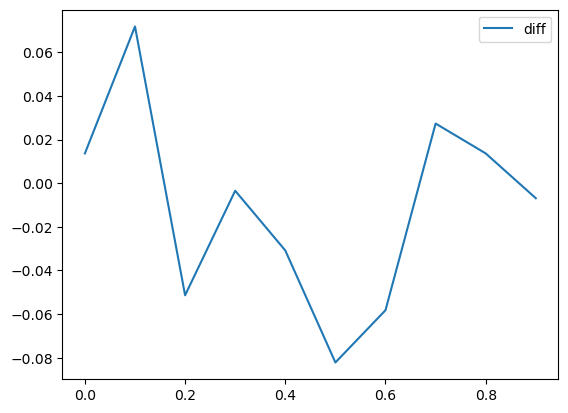

In [8]:
plt.plot(sims, original_test_accs - transferred_test_accs, label='diff')
plt.legend()

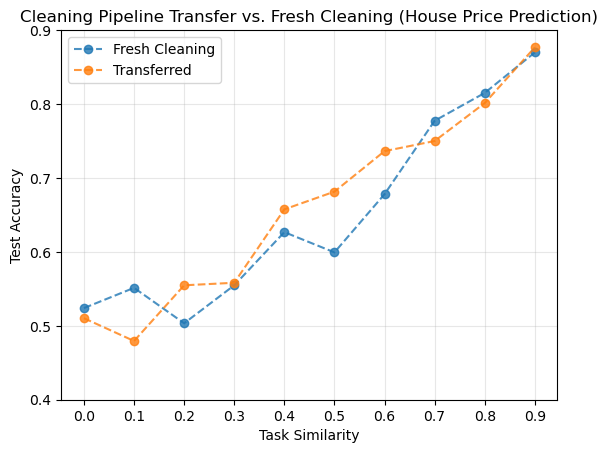

In [11]:
plt.plot(sims, original_test_accs, label='Fresh Cleaning', marker='o', alpha=0.8, linestyle='dashed')
plt.plot(sims, transferred_test_accs, label='Transferred', marker='o', alpha=0.8, linestyle='dashed')

plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0.4, 1, 0.1))

plt.xlabel("Task Similarity")
plt.ylabel("Test Accuracy")

plt.grid(alpha=0.3)
plt.legend()
plt.title("Cleaning Pipeline Transfer vs. Fresh Cleaning (House Price Prediction)")

plt.savefig('plots/house_prices_transfer.png', dpi=300)

In [20]:
#rating_pipeline = load_prep_pipeline(prep_pipeline_price_path, prep_space=space, params=params, data_dir=DATADIR, dataset=dataset)

In [10]:
np.abs(original_test_accs - transferred_test_accs).mean() * 100

3.5958904109589027

In [24]:
size = 876

prep_pipeline = load_prep_pipeline(f'./result/diffprep_fix/{dataset}/{LABEL}_ground_truth/prep_pipeline.pth', space, params, DATADIR, dataset)
task_df = pd.read_csv(f'./data/{dataset}/data.csv')
X_clean = prep_pipeline(task_df.drop(['SalePrice>150k'], axis=1).iloc[:size, :], is_fit=True, X_type="train").detach().numpy()
y_label = (task_df['SalePrice>150k'].values == 'Y').astype(int)
preprocessed_df = pd.DataFrame(X_clean)
preprocessed_df['label'] = y_label[:size]
preprocessed_df.to_csv(f'./house_prices_transfer/cleaned_data_{dataset}_ground_truth.csv', index=False)

In [28]:
size = 876
task_df = pd.read_csv(f'./data/{dataset}/data.csv')

for sim_ in np.arange(0, 1, 0.1):
    sim = round(sim_, 2)

    prep_pipeline = load_prep_pipeline(f'./result/diffprep_fix/{dataset}/{LABEL}_{sim}/prep_pipeline.pth', space, params, DATADIR, dataset)
    X_clean = prep_pipeline(task_df.drop(['SalePrice>150k'], axis=1).iloc[:size, :], is_fit=True, X_type="train").detach().numpy()

    label_path = f'./result/diffprep_fix/{dataset}/label_{sim}/label.csv'
    labels_sim = pd.read_csv(label_path)
    preprocessed_df = pd.DataFrame(X_clean)
    preprocessed_df['label'] = (labels_sim['label'] == 'Y').astype(int)
    preprocessed_df.to_csv(f'./house_prices_transfer/cleaned_data_{dataset}_with_sim_{sim}.csv', index=False)